In machine learning, the recognition of named entities is an essential subtask of **Natural Language Processing**. It tries to recognize and classify multi-word phrases with special meaning, e.g. `people`, `organizations`, `places`, `dates`, etc.

Named entity recognition comes from **Information Retrieval (IE)**. IE’s job is to transform unstructured data into structured information. In Named Entity Recognition, unstructured data is the text written in natural language and we want to extract important information in a well-defined format eg. `relational database`.

For example, we want to monitor the news for mentions of Covid-19 patients and for each patient we need the name of the responsible `medical` **organization**, **location** and **date**.

The Named Entity Recognition task attempts to correctly detect and classify text expressions into a set of predefined classes. Classes can vary, but very often classes like `people (PER)`, `organizations (ORG)` or `places (LOC)` are used.

There is an increase in the use of **named entity recognition** in **information retrieval**. Modern systems like **Apache Lucene** allow us to extend the query with custom properties. Since named entities are very important in many systems, it is essential to allow the user to use them.

This also applies to search engines like **Google** or **Yahoo**, which try to handle the query containing or asking for named entities differently, for example, they show a box with basic information about the named entities with a link to a database of knowledge. Also, the results of named entities are classified differently.

In [28]:
# for working at google colab, following code will be used

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# downloaded = drive.CreateFile({'id':'1hgrp5MtBgTbVTERp6dM-DoZAdKpv_Aq7'}) # replace the id with id of file we want to access
# downloaded.GetContentFile('ner_dataset.csv') 


In [29]:
import pandas as pd
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [30]:
data.shape

(1048575, 4)

We will need to train a neural network for the **Named Entity Recognition (NER**) task that requires some modifications to the data so that it can easily fit into a neutral network. 

We’ll start this step by extracting the **mappings** needed to train the neural network:

In [31]:
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx

In [32]:
token2idx= get_dict_map(data, 'token')
tag2idx= get_dict_map(data, 'tag')

In [33]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)

Now, we’re going to transform the columns in the data to extract the sequential data for our neural network:

In [34]:
data.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
Word_idx            0
Tag_idx             0
dtype: int64

In [35]:
data["Sentence #"].value_counts().sort_index().head()

Sentence: 1        1
Sentence: 10       1
Sentence: 100      1
Sentence: 1000     1
Sentence: 10000    1
Name: Sentence #, dtype: int64

In [36]:
data_fillna = data.fillna(method='ffill', axis=0)

In [37]:
data_fillna.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
Word_idx      0
Tag_idx       0
dtype: int64

In [38]:
data_group = data_fillna.groupby(['Sentence #'],as_index=False)\
['Word','POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [39]:
data_group.head(2)

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[23271, 28584, 21732, 29456, 26497, 3803, 1785...","[5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 3, 5, 5, ..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[32991, 20339, 32744, 27303, 22870, 1779, 2075...","[12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,..."


We will now divide the data into training and test sets. We are going to create a function to split the data as **LSTM (Long Short-Term Memory) layers** only accept sequences of the same length. Thus, each sentence that appears as an integer in the data must be completed with the same length:

In [40]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [24]:
def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32',
                               padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', 
                             padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags =\
    train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9,
                     random_state=2020)
    
    train_tokens, val_tokens, train_tags, val_tags =\
    train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75,
                     random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tags length:', len(train_tags),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

In [25]:
train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 32372 
train_tags length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


### Training a Neural Network for NER

We will now proceed to train the neural network architecture for our model. Let’s start by importing all the packages we need to train our neural network. 

Next, we’ll create layers that will take the dimensions of the **LSTM layer** and give the maximum length and maximum tags as output:

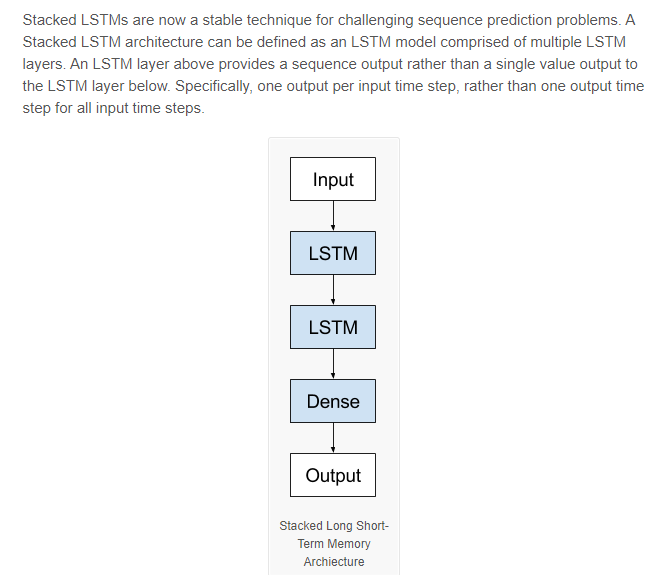

In [27]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

In [28]:
from numpy.random import seed

seed(1)
tensorflow.random.set_seed(2)

In [29]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

Now we will create a helper function that will help us to give the summary of each layer of the neural network model.

In [30]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, 
                        input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True,
                                 dropout=0.2, recurrent_dropout=0.2),
                            merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, 
                   dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    
    return model

Now we will create a function to train our model:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251456   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 64)           49408     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           1105      
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________


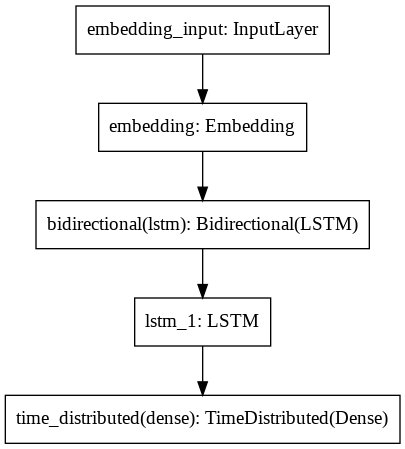

In [31]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, 
                         validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss


model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)

In [32]:
results = pd.DataFrame()
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

26/26 [==============================] - 147s 6s/step - loss: 0.0748 - accuracy: 0.9744 - val_loss: 0.0990 - val_accuracy: 0.9737


# Testing the Model

Now, we will use the **spacy** library to test our **NER model**. We will add input of some lines by ourself and let’s see what we will get after running the code:

In [ ]:
# pip install -U pip setuptools wheel
# pip install -U spacy
# python -m spacy download en_core_web_sm

In [34]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('Hi, My name is Waqas Ali \n I am from Pakistan \n I want to work with Google \n Muhammad (P.B.U.H) is My Inspiration')
displacy.render(text, style = 'ent', jupyter=True)